In [1]:
from pathlib import Path
import pandas as pd
import os
import cdsapi

import torch
import xarray as xr
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download

from aurora import Batch, Metadata, Aurora, rollout

In [2]:
%load_ext autoreload
%autoreload 2

In [61]:
DAY_START = pd.Timestamp("2025-10-07")
DAY_END = pd.Timestamp("2025-10-14")

gt_day_start = pd.Timestamp("2025-10-7")
gt_day_end = pd.Timestamp("2025-10-13")
lead_times = range(1, 6) 
variable = "2m_temperature"

DOWNLOAD_PATH = Path("../../data/era5")
DOWNLOAD_PATH.mkdir(parents=True, exist_ok=True)

# Download all relevant ERA5 inputs for Aurora
Can download 1GB+ of data, depending on date range

In [4]:
c = cdsapi.Client(sleep_max=10)

# Download some ground truth to check interpolation against

In [62]:
def download_era5_day(variable: str, timestamp: pd.Timestamp, filename:str):
        """
        Make a request to Copernicus. 
        Can only request one variable at a time for now, as it will otherwise zip them
        """
        request = {
            "product_type": ["reanalysis"],
            "variable": [variable],
            "year": [str(timestamp.year)],
            "month": [str(timestamp.month).zfill(2)],
            "day": [str(timestamp.day).zfill(2)],
            "time": [
                "00:00",
                "01:00",
                "02:00",
                "03:00",
                "04:00",
                "05:00",
                "06:00",
                "07:00",
                "08:00",
                "09:00",
                "10:00",
                "11:00",
                "12:00",
                "13:00",
                "14:00",
                "15:00",
                "16:00",
                "17:00",
                "18:00",
                "19:00",
                "20:00",
                "21:00",
                "22:00",
                "23:00",
            ],
            "data_format": "netcdf",
            "download_format": "unarchived",
        }
        c.retrieve(
            "reanalysis-era5-single-levels", request, target=filename
        )

print("Downloading all ground truth files...")
gt_path = DOWNLOAD_PATH / "ground_truth"
gt_path.mkdir(parents=True, exist_ok=True)

for gt_day in tqdm(pd.date_range(gt_day_start, gt_day_end)):
    gt_filename = gt_path / f"{gt_day.strftime('%Y-%m-%d')}_ground_truth.nc"
    if not gt_filename.exists():
        download_era5_day(variable, gt_day, str(gt_filename))
print("Ground truth download complete.")

  0%|          | 0/7 [00:00<?, ?it/s]

2025-11-03 13:29:58,363 INFO Request ID is 4209afc9-51b7-4044-971d-76d555983042
2025-11-03 13:29:58,581 INFO status has been updated to accepted
2025-11-03 13:30:07,472 INFO status has been updated to successful


4ae94caa8317e1107ebe6df136d41298.nc:   0%|          | 0.00/34.1M [00:00<?, ?B/s]

 14%|█▍        | 1/7 [00:19<01:58, 19.80s/it]2025-11-03 13:30:17,019 INFO Request ID is 5669145f-2190-4cbf-957a-7e2a291a2144
2025-11-03 13:30:17,186 INFO status has been updated to accepted
2025-11-03 13:30:26,035 INFO status has been updated to running
2025-11-03 13:30:59,400 INFO status has been updated to successful


318d67c0c5528d5ac8b9cf12984430d0.nc:   0%|          | 0.00/34.0M [00:00<?, ?B/s]

Recovering from connection error [IncompleteRead(21461184 bytes read, 14199467 more expected)], attempt 1 of 500
Retrying in 10 seconds


318d67c0c5528d5ac8b9cf12984430d0.nc:  59%|#####8    | 20.0M/34.0M [00:00<?, ?B/s]

Recovering from connection error [IncompleteRead(4079616 bytes read, 10609515 more expected)], attempt 2 of 500
Retrying in 10 seconds


318d67c0c5528d5ac8b9cf12984430d0.nc:  68%|######7   | 23.0M/34.0M [00:00<?, ?B/s]

 29%|██▊       | 2/7 [06:31<18:54, 226.99s/it]2025-11-03 13:36:30,132 INFO Request ID is 41d572f9-fabc-4592-880f-d12b9b9178ad
2025-11-03 13:36:30,309 INFO status has been updated to accepted
2025-11-03 13:36:39,193 INFO status has been updated to running
2025-11-03 13:36:52,224 INFO status has been updated to successful


5715223f257bfb8646d6ba2ae555e25d.nc:   0%|          | 0.00/34.0M [00:00<?, ?B/s]

 43%|████▎     | 3/7 [07:33<10:06, 151.61s/it]2025-11-03 13:37:30,953 INFO Request ID is ca2d5c7b-85a8-429f-ab67-a542ed32533b
2025-11-03 13:37:31,163 INFO status has been updated to accepted
2025-11-03 13:37:45,204 INFO status has been updated to running
2025-11-03 13:37:52,999 INFO status has been updated to successful


91fac468a501fc4f53d9bdf40aaf9324.nc:   0%|          | 0.00/34.0M [00:00<?, ?B/s]

 57%|█████▋    | 4/7 [09:28<06:51, 137.25s/it]2025-11-03 13:39:28,465 INFO Request ID is 90eccbef-3e98-497c-b007-9ae15f4d27f4
2025-11-03 13:39:28,647 INFO status has been updated to accepted
2025-11-03 13:39:42,788 INFO status has been updated to running
2025-11-03 13:39:50,563 INFO status has been updated to successful


814df1de61e7eafc44c6076971b265e6.nc:   0%|          | 0.00/34.1M [00:00<?, ?B/s]

 71%|███████▏  | 5/7 [11:02<04:02, 121.38s/it]2025-11-03 13:41:00,023 INFO Request ID is 126cf710-c712-4161-8004-cdd6938d3163
2025-11-03 13:41:00,203 INFO status has been updated to accepted
2025-11-03 13:41:32,411 INFO status has been updated to successful


eb6e396127f04501a3315541de9de412.nc:   0%|          | 0.00/34.0M [00:00<?, ?B/s]

 86%|████████▌ | 6/7 [11:46<01:35, 95.11s/it] 2025-11-03 13:41:43,461 INFO Request ID is a0cf4d98-65b7-44c1-91e1-cca4c4b125e1
2025-11-03 13:41:43,652 INFO status has been updated to accepted
2025-11-03 13:42:05,458 INFO status has been updated to successful


982295ebfbf90306093f3d0bbfee7b4d.nc:   0%|          | 0.00/34.0M [00:00<?, ?B/s]

100%|██████████| 7/7 [12:18<00:00, 105.44s/it]

Ground truth download complete.


# Setup Aurora Model & Inference

In [6]:
from dataclasses import dataclass
from typing import Optional
import os

import numpy as np

@dataclass
class Prediction(object):

    temperature: np.ndarray  # Temperature data at 2m height

    def to_file(self, filename):
        """
        Save the prediction data to a file as float16 to save space.
        """
        data_to_save = self.temperature.astype(np.float16)
        
        # Use np.savez_compressed for better compression
        np.savez_compressed(
            os.path.expanduser(filename),
            temperature=data_to_save,
        )
    
    def from_file(filename) -> Optional['Prediction']:
        """
        Load the prediction data from a file.
        """
        try:
            
            data = np.load(os.path.expanduser(filename))
            return Prediction(
                temperature=data['temperature'],
            )
        except FileNotFoundError:
            return None

    def get(self, variable: str) -> Optional[np.ndarray]:
        """
        Get a specific variable from the prediction.
        """
        if variable == "2m_temperature":
            return self.temperature
        raise NotImplementedError(f"Variable {variable} not implemented.")

In [52]:
gt_day_str = "2025-10-07"
lead_time_days = '4'
pred_dir = DOWNLOAD_PATH / "predictions" / f"GT_{gt_day_str}"
pred_safe_path = pred_dir / f"LEAD_{lead_time_days}d.npz" 

In [53]:
preds = Prediction.from_file(pred_safe_path)

In [54]:
print(preds.temperature.shape)

(24, 721, 1440)


In [55]:
import sys
sys.path.append("../")
from backend.prediction import Prediction
from scipy.interpolate import PchipInterpolator

def hermit_interp(data: np.ndarray, prefix: int, step_size=6) -> np.ndarray:
        """
        Interpolates a tensor with 6-hourly timestamps to hourly resolution
        using Piecewise Cubic Hermite Interpolating Polynomial (PCHIP).
        # NOTE: last hour of data is only for interpolation purposes and truncated

        Args:
            data (np.ndarray): The input data tensor with shape (x, 721, 1440).
            prefix (int): Number of initial hours to skip in the output.

        Returns:
            np.ndarray: The interpolated data tensor with shape (step_size * (x-prefix) - 1, 721, 1440).
        """
        # Original times: 0, 6, 12, ..., 246 hours (41 * 6)
        t_original = np.arange(data.shape[0]) * step_size

        # New times: 0, 1, 2, ..., 246 hours.
        t_new = np.arange(t_original[-1] + 1)

        interpolator = PchipInterpolator(t_original, data, axis=0)

        data_hourly = interpolator(t_new)
        # remove first (couple) and last datapoint (only there for interpolation)
        start_preds = (prefix - 1) * step_size + 1
        return data_hourly[start_preds:-1]

# NOTE: Works
def _post_process_generic(data, add_first_row=True):
        # aurora post-process
        # Make latitude go from -87.5 to 90.0 instead of decreasing order
        # duplicate the first row for a -90.0 prediction        
        data = data.squeeze().flip(dims=(-2,))
        if add_first_row:
            data = torch.cat((data[0].unsqueeze(0), data))
        # convert longitude 0..360 -> -180..180 by rolling half the width
        shift = data.shape[-1] // 2
        data = torch.roll(data, shifts=shift, dims=-1)
        return data


def process_prediction(batch: Batch, preds) -> Prediction:
        # also include last of batch, so that interpolation for first 6 hours is possible
        temp_preds = [_post_process_generic(batch.surf_vars["2t"][:, i], add_first_row=False) for i in [0, 1]]

        for pred in preds:
            temp_preds.append(_post_process_generic(pred.surf_vars["2t"]))  

        return Prediction(
            temperature = hermit_interp(torch.stack(temp_preds, dim=0).numpy(), prefix=2)
        )  

def rmse(a,b):
      return np.sqrt(((np.asarray(a) - np.asarray(b)) ** 2).mean())        

In [56]:
gt = xr.open_dataset("../data/era5/2025-10-07_ground_truth.nc", engine="netcdf4")
gt_data = _post_process_generic(torch.Tensor(gt["t2m"].to_numpy()), add_first_row=False)

In [57]:
gt_data.shape

torch.Size([24, 721, 1440])

In [58]:
preds.temperature.shape

(24, 721, 1440)

## Plot performance for all predicted hours -- including the Hermit interpolation

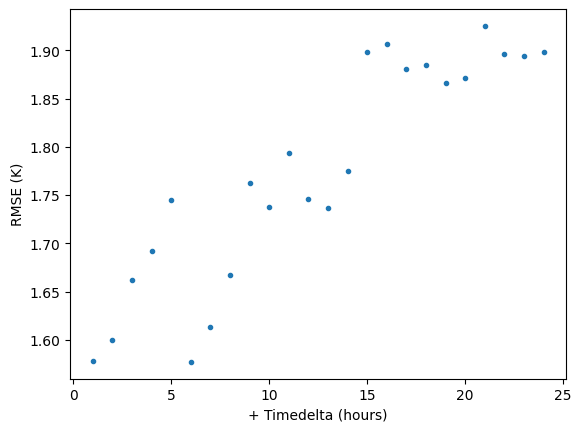

In [59]:
rmses = []
offset = 0
for i in range(offset, len(gt_data)):
    gt_data_slice = gt_data[i]
    rmses.append(rmse(preds.temperature[i - offset], gt_data_slice))

plt.plot(np.arange(1, len(gt_data) - offset + 1), rmses, ".")
plt.ylabel("RMSE (K)")
plt.xlabel("+ Timedelta (hours)");

In [ ]:
results = []
hourly_rmse_data = {} 

for gt_day in pd.date_range(gt_day_start, gt_day_end):
    gt_day_str = gt_day.strftime('%Y-%m-%d')
    print(f"--- Processing GT Day: {gt_day_str} ---")
    hourly_rmse_data[gt_day_str] = {}

    gt_filename = gt_path / f"{gt_day_str}_ground_truth.nc"
    gt_ds = xr.open_dataset(gt_filename, engine="netcdf4")
    
    # Process GT with add_first_row=False to match predictions
    gt_data = _post_process_generic(torch.Tensor(gt_ds["t2m"].to_numpy()), add_first_row=False)
    
    for lead in lead_times:
   
        pred_path = DOWNLOAD_PATH / "predictions" / f"GT_{gt_day_str}" / f"LEAD_{lead}d.npz"
        preds = Prediction.from_file(str(pred_path))
        if preds is None:
            print(f"  Skipping: {pred_path} (File not found)")
            break
            
        if preds.temperature.shape != gt_data.shape:
            print(f"FATAL: Shape mismatch for LEAD={lead}")
            print(f"Pred shape: {preds.temperature.shape}, GT shape: {gt_data.shape}")
            break

        # Calculate Mean RMSE for the whole day
        mean_rmse_day = rmse(preds.temperature, gt_data)
        results.append({
            "gt_day": gt_day,
            "lead_time": lead,
            "mean_rmse": mean_rmse_day
        })
        
        # Calculate and store hourly RMSE
        rmses_hourly = []
        for i in range(24):
            gt_data_slice = gt_data[i]
            pred_data_slice = preds.temperature[i]
            rmses_hourly.append(rmse(pred_data_slice, gt_data_slice))
        
        hourly_rmse_data[gt_day_str][lead] = rmses_hourly

--- Processing GT Day: 2025-10-07 ---
--- Processing GT Day: 2025-10-08 ---
--- Processing GT Day: 2025-10-09 ---
--- Processing GT Day: 2025-10-10 ---
--- Processing GT Day: 2025-10-11 ---
--- Processing GT Day: 2025-10-12 ---
--- Processing GT Day: 2025-10-13 ---


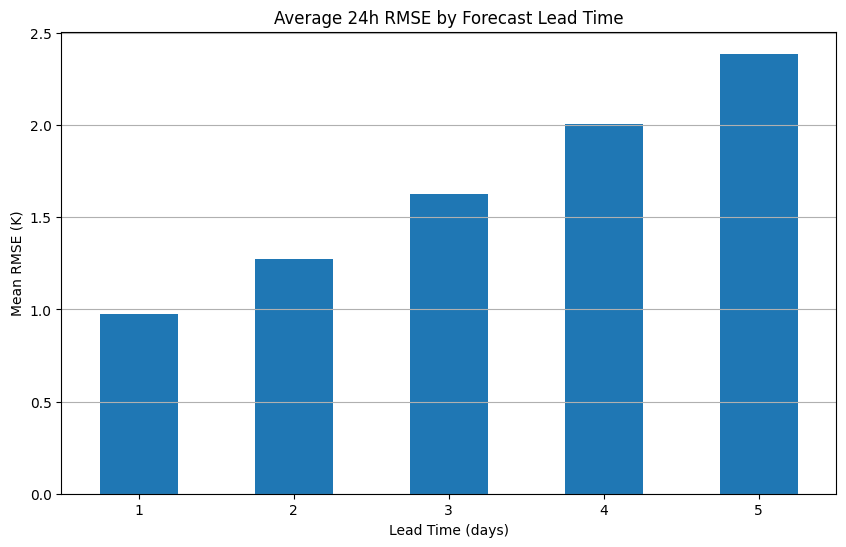

In [66]:
df_results = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
df_results.groupby('lead_time')['mean_rmse'].mean().plot(
    kind='bar',
    title='Average 24h RMSE by Forecast Lead Time',
    ylabel='Mean RMSE (K)',
    xlabel='Lead Time (days)',
    rot=0
)
plt.grid(axis='y')
plt.show()

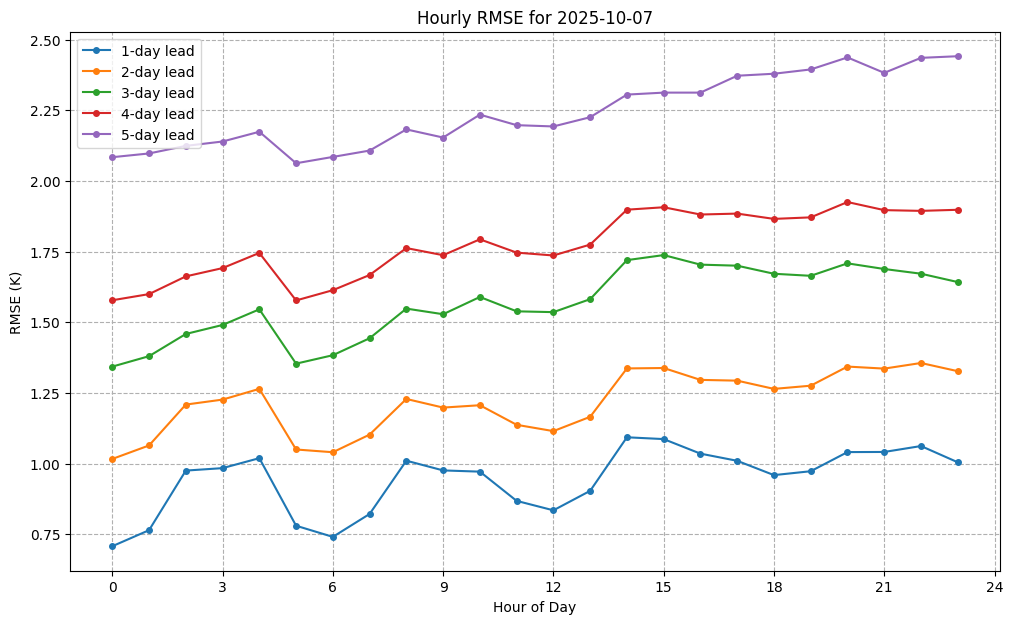

In [67]:
day_to_plot = gt_day_start.strftime('%Y-%m-%d')

plt.figure(figsize=(12, 7))
for lead, hourly_rmses in hourly_rmse_data[day_to_plot].items():
    plt.plot(np.arange(24), hourly_rmses, label=f'{lead}-day lead', marker='o', markersize=4)

plt.title(f'Hourly RMSE for {day_to_plot}')
plt.ylabel("RMSE (K)")
plt.xlabel("Hour of Day")
plt.xticks(np.arange(0, 25, 3))
plt.legend()
plt.grid(True, linestyle='--')
plt.show()